# Learning dataset

The main goal of this notebook is to explore dataset and understand data, how to preprocess it, and just find try to find some patterns.

Prerequirements to run this notebook:
* download all libraries mentioned in `requirements.txt`
* download [filtered ParaNMT-detox corpus dataset](https://github.com/skoltech-nlp/detox/releases/download/emnlp2021/filtered_paranmt.zip)
* unzip archive via graphical interface (ui.py) or just by hands to a directory `../data/raw/filtered_paranmt/filtered.tsv`

Basic information about the dataset
* `reference` (str) - First item from the pair
* `ref_tox` (float) - toxicity level of reference text
* `translation` (str) - second item from the pair - paraphrazed version of the reference
* `trn_tox` (float) - toxicity level of translation text
* `similarity` (float) - cosine similarity of the texts
* `lenght_diff` (float) - relative length difference between texts

In [75]:
import pandas as pd

df = pd.read_table('../data/raw/filtered_paranmt/filtered.tsv', index_col=0)

df.head()

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,"If Alkar is flooding her with psychic waste, t...","if Alkar floods her with her mental waste, it ...",0.785171,0.010309,0.014195,0.981983
1,Now you're getting nasty.,you're becoming disgusting.,0.749687,0.071429,0.065473,0.999039
2,"Well, we could spare your life, for one.","well, we can spare your life.",0.919051,0.268293,0.213313,0.985068
3,"Ah! Monkey, you've got to snap out of it.","monkey, you have to wake up.",0.664333,0.309524,0.053362,0.994215
4,I've got orders to put her down.,I have orders to kill her.,0.726639,0.181818,0.009402,0.999348


# Statistics for numerical features 

In this block we will look at the numerical features `similarity`, `lenght_diff`, `ref_tox` and `trn_tox`. Main goal is to understand data better and determine appropriate preprocessing techniques to use.

In [19]:
# check if any null values exists
df.isna().any()

reference      False
translation    False
similarity     False
lenght_diff    False
ref_tox        False
trn_tox        False
dtype: bool

In [45]:
# determine how 'different' references from a translation
df.similarity.describe()

count    577777.000000
mean          0.758469
std           0.092695
min           0.600001
25%           0.681105
50%           0.754439
75%           0.831244
max           0.950000
Name: similarity, dtype: float64

In [70]:
# see how toxic and non-toxis messages differs in length
df.lenght_diff.describe()

count    577777.000000
mean          0.157652
std           0.108057
min           0.000000
25%           0.066667
50%           0.141791
75%           0.238095
max           0.400000
Name: lenght_diff, dtype: float64

count    577777.000000
mean          0.541372
std           0.457571
min           0.000033
25%           0.012171
50%           0.806795
75%           0.990469
max           0.999724
Name: ref_tox, dtype: float64


<AxesSubplot: ylabel='Frequency'>

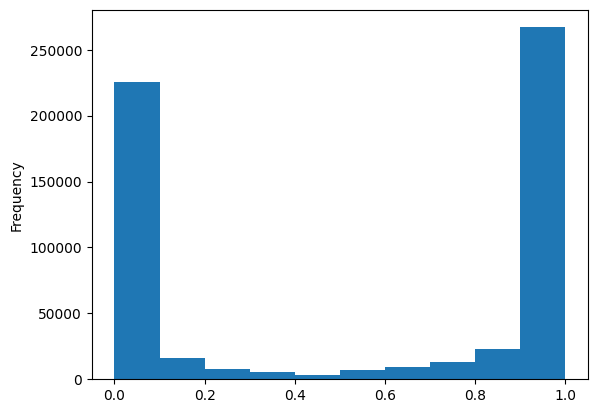

In [37]:
# determine how 'toxic' initial references (trying to find outliers)
print(df.ref_tox.describe())

df.ref_tox.plot.hist()

count    577777.000000
mean          0.434490
std           0.458904
min           0.000033
25%           0.000707
50%           0.085133
75%           0.973739
max           0.999730
Name: trn_tox, dtype: float64


<AxesSubplot: ylabel='Frequency'>

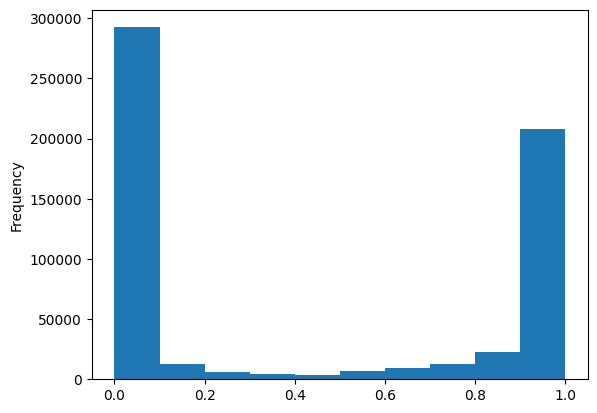

In [39]:
# determine how 'toxic' translations are (also trying to find outliers)
print(df.trn_tox.describe())

df.trn_tox.plot.hist()

### Basic conclusions

First observation is that there are no null values, yay.

Second is that `reference` and `translation` texts on average provide 75% simmilarity (with 9% std), which is pretty good. Also percentile statistics showed that there are no 'radical' outliers in text differences (as lowest score is 0.6 with mean=0.75 and std=0.09).

Worth mentioning is that `ref_tox` and `trn_tox` values are mixed. From my initial understanding of the dataset, I got an idea that `translation` messages are meant to be the toxic one, when `references` otherwise. However this idea is false as we can see from the descriptions above. Also in both `ref_tox`  and `trn_tox` we can see that values tend to 0 or 1, so in preprocessing step we should consider what to do with values in between.

We can also see that toxic and non-toxic texts differs in length, however I failed to understand how score is calculated. So for this iteration I will ingone `lenght_diff` feature.

Data _seems to_ have little-to-no outliers based on statistics seen above. Nevertheless, some edge-cases should be considered/filtered (such as 0.5 toxisity rated) in preprocessing step just to be safe.

### Initial hypothesys for data preprocessing \[1\]

1.1. Swapping features `reference` and `translation` to a `toxic` and `non-toxic` based on a `ref_tox` and `trn_tox` values should be more helpfull, that supposing that whole `regerence`'s are non-toxic, and `translation` is toxic

1.2 Threashold of 'toxisity difference' (absolute/square difference between `fev_tox` and `trn_tox`) could help to make data more representable

1.3 Threashold of `simmilarity` can help to remove outliers from the data and make translation keep more sense



# Statistics for text features

Analyzing`reference` and `translation` features. Trying to find some patterns in single-words usage.

In [84]:
from nltk.tokenize import word_tokenize

# tokenize just for better stats
df['ref_tok'] = df.reference.str.lower().apply(word_tokenize)
df['trn_tok'] = df.translation.str.lower().apply(word_tokenize)

In [102]:
from nltk.probability import FreqDist
from itertools import chain

# calculate words frequency for reference/translation and total
ref_fd = FreqDist(chain.from_iterable(df.ref_tok))
trn_fd = FreqDist(chain.from_iterable(df.trn_tok))

fd = (trn_fd + ref_fd)

In [103]:
# see most common words in the dataset, and just determine what to include in stop words
fd.most_common(100)

[('.', 878932),
 (',', 723660),
 ('you', 468420),
 ('the', 440699),
 ('i', 359454),
 ('a', 314563),
 ('to', 287847),
 ('and', 263704),
 ('of', 187476),
 ("'s", 183490),
 ('?', 182180),
 ('it', 161660),
 ("n't", 141492),
 ('he', 140435),
 ('in', 137649),
 ('that', 132509),
 ('!', 131892),
 ('do', 114825),
 ('your', 110881),
 ('...', 105844),
 ('me', 104992),
 ('is', 97490),
 ('my', 90528),
 ('with', 85907),
 ("'re", 83004),
 ('was', 82462),
 ('we', 78684),
 ('have', 77793),
 ('for', 75958),
 ('this', 75750),
 ('be', 73601),
 ('on', 72920),
 ('if', 72415),
 ('what', 72040),
 ('``', 69080),
 ('like', 65820),
 ('him', 64641),
 ('they', 63591),
 ('but', 62660),
 ("'m", 62423),
 ('his', 60380),
 ('out', 57146),
 ('are', 54976),
 ('up', 54301),
 ('her', 53517),
 ("''", 52661),
 ('not', 52369),
 ("'ll", 51828),
 ('get', 51281),
 ('all', 48532),
 ('so', 48486),
 ('she', 47647),
 ('just', 44800),
 ('know', 43144),
 ('as', 38371),
 ('who', 38074),
 ('one', 37379),
 ('want', 37123),
 ('or', 36249)

In [156]:
import numpy as np

# calculate mean/std toxisity levels for each word (from most popular one)
word_tox = dict()

# for each row in dataset
for (_, _, _, _, ref_tox, trn_tox, ref_tok, trn_tok) in df.values:
    
    # for readibility
    grouped_data = [(ref_tok, ref_tox), (trn_tok, trn_tox)]
    
    # iterate through all tokens and add their' toxisity value to dict
    for (words, tox_level) in grouped_data:
        for word in words:
            
            if word not in word_tox:
                word_tox[word] = []
            
            word_tox[word].append(tox_level)

# convert all values to numpy for faster statistics
for word in word_tox:
    word_tox[word] = np.array(word_tox[word])

In [209]:
# highlight words with high toxisity level (>0.6) and low std (<0.2) for common words (>50)
# all such perparameters for filtering could be tuned 
for word, tox_levels in word_tox.items():
    if tox_levels.std() < 0.2 and tox_levels.mean() > 0.6 and tox_levels.size > 50:
        print('{}\t{:.3f}\t{:.3f}'.format(word.ljust(10, ' '), tox_levels.mean(), tox_levels.std()))

ass       	0.987	0.071
crap      	0.952	0.163
shit      	0.988	0.065
bitch     	0.992	0.061
fuck      	0.991	0.067
fucking   	0.973	0.106
bastard   	0.970	0.137
fools     	0.949	0.177
'shut     	0.973	0.131
damn      	0.936	0.194
stupid    	0.968	0.145
whore     	0.961	0.155
motherfucker	0.999	0.002
pussy     	0.992	0.065
fucked    	0.989	0.064
bullshit  	0.990	0.052
goddamn   	0.985	0.053
fuckin    	0.952	0.131
asshole   	0.988	0.074
idiot     	0.971	0.136
dumbass   	0.990	0.071
ridiculous	0.922	0.182
shits     	0.933	0.196
ejaculated	0.894	0.193
idiots    	0.996	0.047
bitches   	0.981	0.111
pathetic  	0.977	0.085
penises   	0.954	0.156
faggot    	0.995	0.010
dammit    	0.993	0.056
pussies   	0.989	0.060
dumb-ass  	0.998	0.008
bastards  	0.986	0.093
jerk-off  	0.954	0.160
whores    	0.962	0.145
scumbag   	0.998	0.006
fuck-up   	0.956	0.146
assholes  	0.989	0.071
repugnant 	0.919	0.142
fags      	0.988	0.066
traitorous	0.905	0.178
penis     	0.944	0.192
motherfuckers	0.998	0.013
fag   

### Basic conclusions

It's fair to say that some words appear mostly in 'classified-as-toxic' sentences. As we can see from above, most of them are curse words. Most of the words the algorithm filtered resulted with high mean toxicity-value (>0.9) and low standard deviation (<0.2) even with loose parameters. This shows strong correlation between such words and toxic value.

Context-dependend words such as 'kill' didn't resulted in a high-mean-low-std (HMLS) list, which shows that sigle-word analysis is not enought to remove toxicity from the given queries. Bigrams and more advanced techniques should be used to analyse and preprocess dataset better.

Dataset is biased towards some topics: WWE (wrestling company) and Enrique (I can guess a celebrity) resulted in a list of of HMLS-words, which ideally should not happen. So such things should be considered during evaluation.

# Outcomes of the session 
1.1 During data preprocessing introduce new features `toxic` and `non-toxic` based on `ref_tox` and `trn_tox` scores.

1.2 Introduce `toxisity_difference` threashold duting preprocessing.

1.3 Tune which `simmilarity` value to consider in order to save sence of the sentences.

1.4 Some of the curse words tend to results in higher toxicity rate, so emphasizing and removing such words may increase model 
performance.

1.5 Further analysis of bigrams and other more complex word combinations should be considered in order to find more patterns in data.

1.6 Baseline solution may be a dict of all high-mean-low-std words that should be replaced to synonims or just removed


# Credits

Notebook created by Polina Zelenskaya\
Innopolis University DS21-03

Github: [github.com/cutefluffyfox](https://github.com/cutefluffyfox)\
Email: p.zelenskaya@innopolis.university
